In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

SECONDS_PER_MINUTE = 60
SECONDS_PER_HOUR = 60 * SECONDS_PER_MINUTE
max_inactivity_period = 30 * SECONDS_PER_MINUTE

pd.options.display.float_format = '{:,.2f}'.format


with open('history.csv') as f:
    df = pd.read_csv(f)

df["base_url"] = df["url"].apply(lambda x: x.split("/")[2])
df["date_time"] = df["date"]+" "+ df["time"]
df["date_time"] = pd.to_datetime(df["date_time"])
df["timestamp"] = df["date_time"].apply(lambda x: x.timestamp())
df["time_spent"] = df["timestamp"].shift(1) - df["timestamp"]
df["time_spent"] = df["time_spent"].apply(lambda x: min(x, max_inactivity_period))
df.head(5)

,order,id,date,time,title,url,visitCount,typedCount,transition,base_url,date_time,timestamp,time_spent
0,0,34215,12/3/2022,11:05:54,Export Chrome History - Chrome Web Store,https://chrome.google.com/webstore/detail/expo...,1,0,link,chrome.google.com,2022-12-03 11:05:54,"1,670,065,554.00",NaN
1,1,34214,12/3/2022,11:05:46,Export Chrome History - Chrome Web Store,https://chrome.google.com/webstore/detail/expo...,1,0,link,chrome.google.com,2022-12-03 11:05:46,"1,670,065,546.00",8.00
2,2,34213,12/3/2022,11:05:45,download chrome history - Google Search,https://www.google.com/search?q=download+chrom...,2,0,link,www.google.com,2022-12-03 11:05:45,"1,670,065,545.00",1.00
3,3,34213,12/3/2022,11:05:44,download chrome history - Google Search,https://www.google.com/search?q=download+chrom...,2,0,generated,www.google.com,2022-12-03 11:05:44,"1,670,065,544.00",1.00
4,4,34212,12/3/2022,11:03:32,Chrome Browsing History disappeared and not sh...,https://www.thewindowsclub.com/chrome-browsing...,1,0,link,www.thewindowsclub.com,2022-12-03 11:03:32,"1,670,065,412.00",132.00


In [24]:
filt = df["time_spent"] == max_inactivity_period
len(df[filt]), len(df)

(601, 112143)

In [9]:
from datetime import datetime
print(datetime.now())

2022-12-04 23:08:51.905324


In [103]:
DAYS = 90

df2 = df.groupby("base_url")["time_spent"].sum().reset_index()
df2.sort_values(by="time_spent", ascending=False, inplace=True)
df2["hours_on_site"] = df2["time_spent"] / SECONDS_PER_HOUR
df2["hours_on_site_per_day"] = df2["hours_on_site"] / DAYS

df2

<AxesSubplot: xlabel='log_hours_on_site', ylabel='Count'>

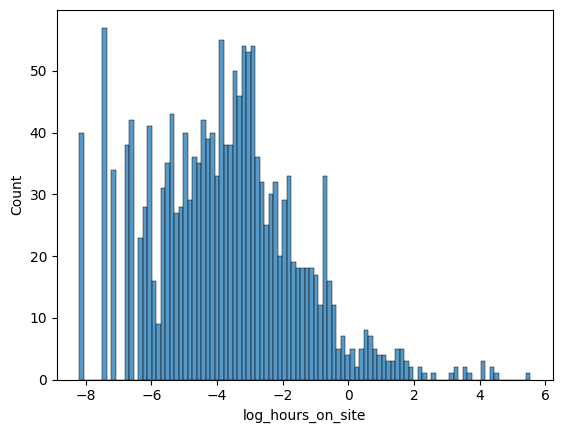

In [65]:
# log scale
df2["log_hours_on_site"] = df2["hours_on_site"].apply(lambda x: np.log(x))
sns.histplot(df2["log_hours_on_site"], bins=100)
# sns.histplot(df2["seconds_on_site"], bins=100)
# plt.yscale('log')

# What would be cool information to display?

1. How many hours per day do I spend on each site?
2. Average hours per visit
3. Correlation betweeen visits

Look into certain "eras" where some idea was being explored -- or like the "theme" of the day or week

Ex . What was I doing in 2018?

- more complicated would have to be done with external connection graph?

So just discretize and see if there are any spikes in visits for a day

so (time_td)/(time_tot) * log(time_total), give a little more weight to sites visited more frequently

In [104]:
# go through all days and see how many hours were spent on each site
import warnings
warnings.filterwarnings('ignore')

ret = pd.DataFrame()
for day in df["date"].unique():
    df3 = df[df["date"] == day].groupby("base_url")["time_spent"].sum().reset_index()
    df3["date"] = day
    df3["hours_today"] = df3["time_spent"] / SECONDS_PER_HOUR

    # where base_url is equal
    df3 = df3.merge(df2[["base_url", "hours_on_site"]], on="base_url", how="left")
    df3["hours_pct"] = df3["hours_today"] / df3["hours_on_site"]
    df3["weight"] = df3["hours_pct"] * np.log(df3["hours_on_site"])

    idx_max = df3["weight"].idxmax()
    ret = ret.append(df3.loc[idx_max], ignore_index=True)

ret.head(5)

,base_url,time_spent,date,hours_today,hours_on_site,hours_pct,weight
0,codeforces.com,"1,800.00",12/3/2022,0.50,22.41,0.02,0.07
1,drive.google.com,"3,673.00",12/2/2022,1.02,4.98,0.20,0.33
2,adventofcode.com,"12,765.00",12/1/2022,3.55,4.53,0.78,1.18
3,www.wolframalpha.com,"3,752.00",11/30/2022,1.04,8.48,0.12,0.26
4,docs.deribit.com,"2,387.00",11/29/2022,0.66,2.02,0.33,0.23
